In [1]:
# # List all directories and files in the current working directory
# for root, dirs, files in os.walk('.'):
#     print("Root directory:", root)
#     print("Subdirectories:", dirs)
#     print("Files:", files)
#     break  # Stop after the first level to avoid printing too much

In [1]:
import os
os.chdir("../")    #commment after first run


In [11]:
#imports
import dask.distributed
import pystac_client
import planetary_computer
import stackstac 
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
import geopandas as gpd
from src.utils import gen_chips


In [12]:
print(os.getcwd())
#should be /home/benchuser/code

/home/benchuser/code


In [4]:
#os.chdir("/home/benchuser/code")

In [13]:
#config setup
import yaml
with open("notebooks/config.yml", "r") as file:
    config = yaml.safe_load(file)
print(config)  # Check the structure of the dictionary


{'sentinel_2': {'collection': 'sentinel-2-l2a', 'time_ranges': ['2023-01-01/2023-03-31', '2023-04-01/2023-06-30', '2023-07-01/2023-09-30', '2023-10-01/2023-12-31'], 'cloud_cover': 1, 'bands': ['B02', 'B03', 'B04', 'B08', 'B11', 'B12'], 'resolution': 10}, 'land_cover': {'collection': 'io-lulc-annual-v02', 'year': '2023-01-02/2023-12-31'}, 'chips': {'sample_size': 100, 'chip_size': 224}, 'output': {'directory': 'notebooks/test_output_dump', 'naming_convention': 's2_{season}_{index:05}.tif'}, 'metadata': {'file': 'metadata.csv'}}


In [20]:
# Sentinel-2 settings
s2_collection = config["sentinel_2"]["collection"]
s2_date_ranges = config["sentinel_2"]["time_ranges"]
s2_bands = config["sentinel_2"]["bands"]
s2_resolution = config["sentinel_2"]["resolution"]
cloud_cover_threshold = config["sentinel_2"]["cloud_cover"]  # Max allowed cloud cover

# Land Cover settings
lc_collection = config["land_cover"]["collection"]
lc_year = config["land_cover"]["year"]  # Year of LC dataset

# Chip settings
sample_size = config["chips"]["sample_size"]  # Grid size for homogeneity check
chip_size = config["chips"]["chip_size"]  # Output chip size

# Output settings
output_dir = config["output"]["directory"]
chip_naming_convention = config["output"]["naming_convention"]

# Metadata settings
metadata_file = config["metadata"]["file"]

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define seasons for indexing
seasons = ["JFM", "AMJ", "JAS", "OND"]

aoi_gdf = gpd.read_file("data/urbans.geojson") # or "data/aois.geojson"


In [21]:
#dask
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=8, threads_per_worker=1)
client = Client(cluster)
print(client.dashboard_link)

/opt/conda/envs/gfm_bench/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44435 instead
  warnings.warn(


http://127.0.0.1:44435/status


In [36]:
def search_s2_scenes(aoi, date_range):
    """
    Searches for Sentinel-2 scenes within the AOI and date range.
    Adds debugging info to identify missing data issues.
    """

    print(f"\n🔎 Searching Sentinel-2 for AOI {aoi.geometry.bounds} during {date_range}")

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )

    # ✅ Print the exact query parameters
    print(f"📌 Querying collection: 'sentinel-2-l2a'")
    print(f"📌 Bounding Box: {aoi.geometry.bounds}")
    print(f"📌 Date Range: {date_range}")
    print(f"📌 Cloud Cover Filter: < {1}%")
    
    s2_search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=aoi.geometry.bounds, 
        datetime=date_range,
        query={"eo:cloud_cover": {"lt": 1}},  # Fix query syntax to dictionary
        sortby=["+properties.eo:cloud_cover"],  # Sort by least cloud cover
        max_items=1,  # Increase items to check for any available data
    )

    # ✅ Print found items
    items = s2_search.item_collection()
    print(f"✅ Found {len(items)} Sentinel-2 scenes")

    # ✅ Print full STAC item properties for debugging
    if len(items) > 0:
        print(f"🛰 First Scene ID: {items[0].id}")
        print(f"🗺 First Scene EPSG: {items[0].properties.get('proj:epsg', 'Unknown')}")
        print(f"📅 Acquisition Date: {items[0].properties.get('datetime', 'Unknown')}")
        print(f"☁️ Cloud Cover: {items[0].properties.get('eo:cloud_cover', 'Unknown')}")
    else:
        print(f"⚠️ No Sentinel-2 data found for this AOI and date range!")

    return list(items)  # Convert ItemCollection to a list of Items
def search_lc_scene(bbox, lc_date_range):
    print(f"Searching for Land Cover scenes within {lc_date_range} for bbox {bbox}")
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )
    lc_search = catalog.search(
        collections=["io-lulc-annual-v02"],
        bbox=bbox,
        datetime=lc_date_range,
    )
    items = lc_search.item_collection()
    print(f"Found {len(items)} Land Cover scenes")
    return list(items)  # Convert ItemCollection to a list of Items

def stack_s2_data(s2_items, s2_bands):
    """
    Stacks Sentinel-2 images, ensuring that the required bands are included and missing bands are handled.
    """

    # ✅ Step 1: Debug available assets before stacking
    print("\n🔎 Checking available assets in Sentinel-2 items...")
    for i, item in enumerate(s2_items[:3]):  # Check the first 3 items
        print(f"🛰 Scene {i + 1}: {item.id}")
        print(f"📦 Available assets: {list(item.assets.keys())}")

    # ✅ Step 2: Filter to only requested bands
    valid_bands = [band for band in s2_bands if all(band in item.assets for item in s2_items)]
   
    # 🚨 Step 3: Check for missing bands
    missing_bands = [band for band in s2_bands if band not in valid_bands]
    if missing_bands:
        print(f"⚠️ Warning: Missing bands {missing_bands}. These will be excluded from stacking.")

    # ✅ Step 4: Stack Sentinel-2 images using only the available bands
    try:
        s2_stack = stackstac.stack(
            s2_items,
            assets=valid_bands,  # Use only bands that are confirmed to exist
            epsg=s2_items[0].properties["proj:epsg"],
            resolution=10,
            fill_value=np.nan
        
        )
       
        print(f"✅ Stacked Sentinel-2 bands: {list(s2_stack.coords['band'].values)}")

        return s2_stack

    except Exception as e:
        print(f"❌ Error stacking Sentinel-2 data: {e}")
        return None
def stack_lc_data(lc_items, s2_epsg):
    if not lc_items:
        print("No Land Cover data found.")
        return None
    try:
        print("Stacking Land Cover images...")
        stacked_data = stackstac.stack(
            lc_items,
            dtype=np.ubyte,
            fill_value=255,
            sortby_date=False,
            epsg=s2_epsg,
            resolution=10,
            bounds_latlon=s2_items[0].bbox,
        ).squeeze()

        stacked_data = stacked_data.chunk(chunks={"x": sample_size, "y": sample_size})
        print("Stacked LC data shape:", stacked_data.shape)
        #print(f"Chunk sizes: {stacked_data.chunks}")   #uncomment for big chunk size 

        return stacked_data

    except Exception as e:
        print(f"Error stacking Land Cover data: {e}")
        return None


def has_missing_values(array):
    """Check if the given array contains NaN values and print only when necessary."""
    has_nan = array.isnull().any().compute()
    if has_nan:
        print("Warning: Missing values detected in the chip!")
    return has_nan

#This process chips goes through time then space, so chips next to each other are from the same location.

def process_chips(aoi, s2_stack, lc_stack, output_dir, global_index, chip_dict):
    chip_count = 0

    print(f"Processing chips for AOI at {aoi.geometry.bounds}")

    # Reproject LC to match S2 CRS if necessary
    if s2_stack.rio.crs != lc_stack.rio.crs:
        print("⚠️ Reprojecting LC to match Sentinel-2 CRS...")
        lc_stack = lc_stack.rio.reproject_match(s2_stack)

    # Ensure LC stack has a band dimension
    if len(lc_stack.shape) == 2:
        lc_stack = lc_stack.expand_dims(dim="band", axis=0)

    # Determine center coordinates
    center_x = lc_stack.shape[1] // 2
    center_y = lc_stack.shape[2] // 2

    for t in range(s2_stack.shape[0]):
        s2_chip = s2_stack.isel(band=slice(None), x=slice(center_x, center_x + chip_size), y=slice(center_y, center_y + chip_size))
        lc_chip = lc_stack.isel(band=slice(None), x=slice(center_x, center_x + chip_size), y=slice(center_y, center_y + chip_size))

        if s2_chip.isnull().all() or lc_chip.isnull().all():
            print(f"⚠️ Skipping chip {global_index}: Empty dataset (NoDataInBounds)")
            continue

        chip_name = f"s2_{global_index:05}.tif"
        lc_chip.rio.to_raster(os.path.join(output_dir, f"lc_{chip_name}"))
        s2_chip.rio.to_raster(os.path.join(output_dir, chip_name))

        print(f"✅ Saved chip {chip_name}")
        chip_dict[(center_x, center_y, t)] = (s2_chip, lc_chip)
        global_index += 1
        chip_count += 1

        if chip_count >= 40:
            print("🚀 Stopping chip generation after 4 time steps.")
            return global_index

    return global_index




In [37]:
global_index = 0
chip_dict = {}  # Initialize chip dictionary

for index, aoi in aoi_gdf.iterrows():
    print(f"Processing AOI {index}")

    # Search for Sentinel-2 images
    s2_items = [search_s2_scenes(aoi, date_range) for date_range in s2_date_ranges]
    s2_items = [item for sublist in s2_items for item in sublist]  # Flatten list

    if not s2_items:
        print(f"Skipping AOI {index}: No Sentinel-2 data found.")
        continue

    print(f"First S2 Item ID: {s2_items[0].id}")
    print(f"First S2 Item Properties: {s2_items[0].properties}")
    print(f"First S2 Item BBox: {s2_items[0].bbox}")

    # Debug: Print available bands before stacking
    print("All available bands in Sentinel-2 scenes:", [list(item.assets.keys()) for item in s2_items])

    # Ensure required bands are available before stacking
    expected_bands = ["B02", "B03", "B04", "B08", "B11", "B12"]  # Includes RGB & SWIR bands
    available_bands = list(set.intersection(*(set(item.assets.keys()) for item in s2_items)))

    # Check for missing bands
    missing_bands = [b for b in expected_bands if b not in available_bands]
    if missing_bands:
        print(f"Warning: Missing bands {missing_bands}. Skipping AOI {index}.")
        continue  # Skip this AOI if required bands are missing

    # Stack Sentinel-2 images
    s2_stack = stack_s2_data(s2_items, expected_bands)

    if s2_stack is None:
        print(f"Skipping AOI {index}: No valid Sentinel-2 data found.")
        continue

    # Debugging: Print available bands in the stack
    print("All bands in s2_stack:", s2_stack.coords["band"].values)

    # Check and assign CRS
    if not hasattr(s2_stack, "rio") or s2_stack.rio.crs is None:
        print(f"Error: s2_stack is missing CRS information. Assigning manually.")
        s2_epsg = s2_items[0].properties["proj:epsg"]
        s2_stack.rio.write_crs(f"epsg:{s2_epsg}", inplace=True)

    print(f"Sentinel-2 CRS: {s2_stack.rio.crs}")

    # Merge time dimension to get a single composite image
    if "time" in s2_stack.dims:
        print("Merging time dimension using median composite...")
        s2_stack = s2_stack.median("time", skipna=True).squeeze()

    if not s2_stack.rio.crs:
        s2_stack.rio.write_crs(f"epsg:{s2_items[0].properties['proj:epsg']}", inplace=True)


    # Search for Land Cover images
    lc_items = search_lc_scene(s2_items[0].bbox, lc_year)
    if not lc_items:
        print(f"Skipping AOI {index}: No valid LC data found.")
        continue

    print(f"First LC Item BBox: {lc_items[0].bbox}")

    # Ensure Sentinel-2 stack is valid before using its CRS
    if s2_stack is not None and hasattr(s2_stack, "rio") and s2_stack.rio.crs is not None:
        lc_stack = stack_lc_data(lc_items, s2_stack.rio.crs.to_epsg())
    else:
        print(f"Error: s2_stack is missing or has no CRS. Skipping AOI {index}.")
        continue  # Skip if Sentinel-2 stack is missing or invalid

    if lc_stack is None:
        print(f"Skipping AOI {index}: No valid LC data found.")
        continue

    # Reproject LC if CRS mismatches
    if s2_stack.rio.crs != lc_stack.rio.crs:
        print("Reprojecting land cover to match Sentinel-2 CRS...")
        lc_stack = lc_stack.rio.reproject(s2_stack.rio.crs)

    # Debugging: Print final data shapes
    print("Final s2_stack shape:", s2_stack.shape)
    print("Final lc_stack shape:", lc_stack.shape)

    # Process chips (Now stores results in chip_dict)
    global_index = process_chips(aoi, s2_stack, lc_stack, output_dir, global_index, chip_dict)

    # Stop after one AOI to check outputs
    # if global_index > 5:
    #     break  
    break

Processing AOI 0

🔎 Searching Sentinel-2 for AOI (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983) during 2023-01-01/2023-03-31
📌 Querying collection: 'sentinel-2-l2a'
📌 Bounding Box: (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983)
📌 Date Range: 2023-01-01/2023-03-31
📌 Cloud Cover Filter: < 1%
✅ Found 1 Sentinel-2 scenes
🛰 First Scene ID: S2B_MSIL2A_20230118T083159_R021_T36RUU_20230120T032254
🗺 First Scene EPSG: 32636
📅 Acquisition Date: 2023-01-18T08:31:59.024000Z
☁️ Cloud Cover: 0.004725

🔎 Searching Sentinel-2 for AOI (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983) during 2023-04-01/2023-06-30
📌 Querying collection: 'sentinel-2-l2a'
📌 Bounding Box: (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983)
📌 Date Range: 2023-04-01/2023-06-30
📌 Cloud Cover Filter: < 1%
✅ Found 1 Sentinel-2 scenes
🛰 First Scene ID: S2B_MSIL2A_20230627T082609_R021_T36RUU_20230627T143503
🗺 Firs

/opt/conda/envs/gfm_bench/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Found 1 Land Cover scenes
First LC Item BBox: [29.769589739624692, 23.97069843799003, 36.23041026037532, 32.035310832136304]
Stacking Land Cover images...


/opt/conda/envs/gfm_bench/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Stacked LC data shape: (11272, 11273)
Final s2_stack shape: (6, 10980, 10980)
Final lc_stack shape: (11272, 11273)
Processing chips for AOI at (31.20416267326229, 30.02337142235983, 31.280433633102717, 30.060612342021983)
✅ Saved chip s2_00000.tif
✅ Saved chip s2_00001.tif
✅ Saved chip s2_00002.tif
✅ Saved chip s2_00003.tif
✅ Saved chip s2_00004.tif
✅ Saved chip s2_00005.tif


In [28]:
#print(s2_stack)

<xarray.DataArray 'stackstac-8c4f7e9ee6a71fdc0023e63b995240c7' (band: 6,
                                                                y: 10980,
                                                                x: 10980)> Size: 6GB
dask.array<nanmedian, shape=(6, 10980, 10980), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * band                                     (band) <U3 72B 'B02' ... 'B12'
  * x                                        (x) float64 88kB 3e+05 ... 4.098...
  * y                                        (y) float64 88kB 3.4e+06 ... 3.2...
    sat:relative_orbit                       int64 8B 21
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    proj:epsg                                int64 8B 32636
    ...                                       ...
    title                                    (band) <U26 624B 'Band 2 - Blue ...
    common_name                              (band) <U6 144B 'blue' ... 'swir22'
  

In [29]:
#print(s2_stack.isel(band=0))

<xarray.DataArray 'stackstac-8c4f7e9ee6a71fdc0023e63b995240c7' (y: 10980,
                                                                x: 10980)> Size: 964MB
dask.array<getitem, shape=(10980, 10980), dtype=float64, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/22)
    band                                     <U3 12B 'B02'
  * x                                        (x) float64 88kB 3e+05 ... 4.098...
  * y                                        (y) float64 88kB 3.4e+06 ... 3.2...
    sat:relative_orbit                       int64 8B 21
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    proj:epsg                                int64 8B 32636
    ...                                       ...
    title                                    <U26 104B 'Band 2 - Blue - 10m'
    common_name                              <U6 24B 'blue'
    center_wavelength                        float64 8B 0.49
    full_width_half_max                      float64 8B 0.098


In [33]:
#print("First four chips content:", first_four_chips)

First four chips content: (<xarray.DataArray 'stackstac-8c4f7e9ee6a71fdc0023e63b995240c7' (band: 6,
                                                                y: 224, x: 224)> Size: 2MB
dask.array<getitem, shape=(6, 224, 224), dtype=float64, chunksize=(1, 224, 224), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * band                                     (band) <U3 72B 'B02' ... 'B12'
  * x                                        (x) float64 2kB 3.564e+05 ... 3....
  * y                                        (y) float64 2kB 3.344e+06 ... 3....
    sat:relative_orbit                       int64 8B 21
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    proj:epsg                                int64 8B 32636
    ...                                       ...
    title                                    (band) <U26 624B 'Band 2 - Blue ...
    common_name                              (band) <U6 144B 'blue' ... 'swir22'
    center_wavelength                        (band)

Available bands in chip 1: ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']
Error visualizing Land Cover chip 1: Invalid shape (1, 224, 224) for image data


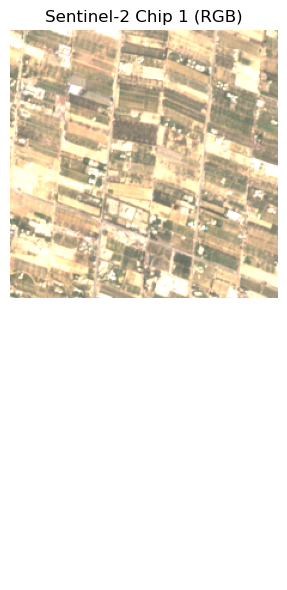

In [39]:
import matplotlib.pyplot as plt

# Check if chips exist
if not chip_dict:
    print("No chips were saved. Check for errors in processing.")
else:
    first_location = next(iter(chip_dict.keys()))  # Get first (i, j) key
    first_four_chips = [chip_dict[first_location]]

    num_chips = len(first_four_chips)
    fig, axes = plt.subplots(2, num_chips, figsize=(5 * num_chips, 6))

    for idx, (s2_chip, lc_chip) in enumerate(first_four_chips):
        if s2_chip is None or lc_chip is None:
            print(f"Skipping chip {idx+1}: Missing data.")
            continue

        # Adjust indexing for single-chip cases
        if num_chips == 1:
            ax_s2, ax_lc = axes  # Unpack single-row axes
        else:
            ax_s2, ax_lc = axes[:, idx]  # Use both subplots for each chip

        ### ✅ Fix Sentinel-2 Image Display ###
        try:
            available_bands = list(s2_chip.coords["band"].values)  
            print(f"Available bands in chip {idx+1}: {available_bands}")

            if all(b not in available_bands for b in ["B04", "B03", "B02"]):
                print(f"⚠️ Chip {idx+1} has no valid RGB bands. Displaying single-band.")
                
                # Select a single-band fallback (e.g., B11 or any available)
                selected_band = "B11" if "B11" in available_bands else available_bands[0]
                grayscale_image = s2_chip.sel(band=selected_band).compute()
                cmap = "gray"

                ax_s2.imshow(grayscale_image, cmap=cmap)
                ax_s2.set_title(f"Sentinel-2 Chip {idx+1} ({selected_band})")
            else:
                # Get valid RGB bands from available ones
                selected_bands = [b for b in ["B04", "B03", "B02"] if b in available_bands]
                if len(selected_bands) < 3:
                    print(f"⚠️ Warning: Not all RGB bands available for chip {idx+1}. Using {selected_bands}.")

                # Extract RGB image
                rgb_image = s2_chip.sel(band=selected_bands).transpose("y", "x", "band").compute()
                ax_s2.imshow(rgb_image.clip(0, 3000) / 3000)
                ax_s2.set_title(f"Sentinel-2 Chip {idx+1} (RGB)")

            ax_s2.axis("off")

        except Exception as e:
            print(f"Error visualizing Sentinel-2 chip {idx+1}: {e}")
            ax_s2.axis("off")

        ### ✅ Fix Land Cover Image Display ###
        try:
            lc_data = lc_chip.compute() if lc_chip.chunks else lc_chip
            ax_lc.imshow(lc_data, cmap="tab10")  
            ax_lc.set_title(f"Land Cover Chip {idx+1}")
            ax_lc.axis("off")

        except Exception as e:
            print(f"Error visualizing Land Cover chip {idx+1}: {e}")
            ax_lc.axis("off")

    plt.tight_layout()
    plt.show()


ValueError: too many values to unpack (expected 2)

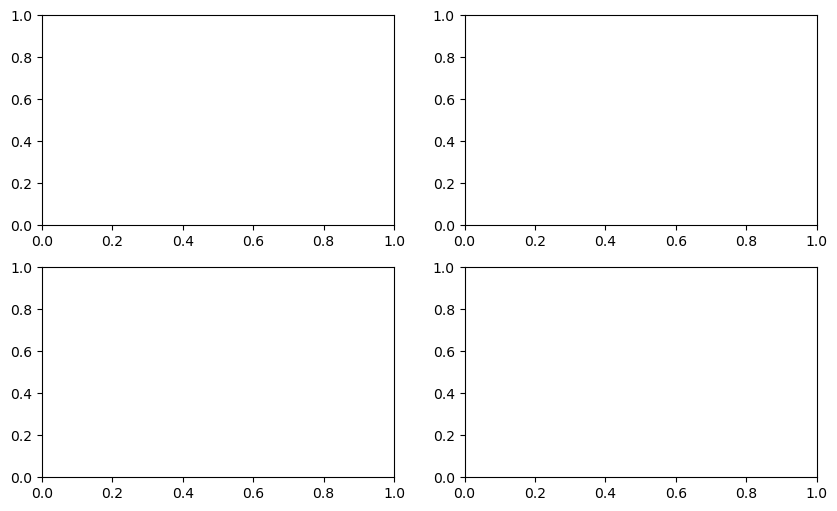

In [35]:
# import matplotlib.pyplot as plt

# # Check if chips exist
# if not chip_dict:
#     print("No chips were saved. Check for errors in processing.")
# else:
#     first_location = next(iter(chip_dict.keys()))  # Get first (i, j) key
#     first_four_chips = chip_dict[first_location][:4]  # Get first 4 chips

#     num_chips = len(first_four_chips)
#     fig, axes = plt.subplots(2, num_chips, figsize=(5 * num_chips, 6))

#     for idx, (s2_chip, lc_chip) in enumerate(first_four_chips):
#         if s2_chip is None or lc_chip is None:
#             print(f"Skipping chip {idx+1}: Missing data.")
#             continue

#         # Adjust indexing for single-chip cases
#         if num_chips == 1:
#             ax_s2, ax_lc = axes  # Unpack single-row axes
#         else:
#             ax_s2, ax_lc = axes[:, idx]  # Use both subplots for each chip

#         try:
#             print(f"Available bands in chip {idx+1}: {s2_chip.coords['band'].values}")

#             desired_bands = [4, 3, 2]
#             valid_bands = s2_chip.coords["band"].values
#             selected_bands = [b for b in desired_bands if b in valid_bands]

#             if selected_bands:
#                 rgb_image = s2_chip.sel(band=selected_bands).transpose("y", "x", "band")
#             else:
#                 print(f"⚠️ Chip {idx+1} has no valid RGB bands. Displaying as grayscale.")
#                 rgb_image = s2_chip  # Use as grayscale

#             rgb_image = rgb_image.compute() if rgb_image.chunks else rgb_image
#             ax_s2.imshow(rgb_image.clip(0, 3000) / 3000, cmap="gray" if "band" not in s2_chip.dims else None)
#             ax_s2.set_title(f"Sentinel-2 Chip {idx+1}")
#             ax_s2.axis("off")

#         except Exception as e:
#             print(f"Error visualizing Sentinel-2 chip {idx+1}: {e}")
#             ax_s2.axis("off")

#         # Land Cover Visualization
#         try:
#             lc_data = lc_chip.compute() if lc_chip.chunks else lc_chip
#             ax_lc.imshow(lc_data, cmap="tab10")  
#             ax_lc.set_title(f"Land Cover Chip {idx+1}")
#             ax_lc.axis("off")
#         except Exception as e:
#             print(f"Error visualizing Land Cover chip {idx+1}: {e}")
#             ax_lc.axis("off")

#     plt.tight_layout()
#     plt.show()


In [19]:
print(chip_dict)

{}
